# Kalman Filter

### import modules

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import visual as vis
import DataGen as dg
from KalmanFilterCV import KalmanFilterCV
from KalmanFilter import KalmanFilter

In [77]:
# total iterations for the simulation
total_iters = 100
# start and end time of simulation
time_lims = [0,100]
# animation frame display interval in milliseconds
animation_interval_ms = 200

### set KF / data noise variables

In [78]:
# standard deviation of gaussian noise to be added in position
pos_dev = [2.2, 2.2, 0.05]
# standard deviation of gaussian noise to be added in acceleration
acc_dev = [0.1, 0.1, 0.01]
# initial noise estimate in state (position, velocity)
p_diag = np.matrix([100, 100, 100, 600, 600, 600])
# noise in acceleration
q_diag = np.matrix(1e-2 * np.ones(3))
# meausurement noise
r_diag = pos_dev

## Kalman Filter (constant velocity model, no imu input)

### initialise path generator

In [91]:
# the path generator function
gen = dg.PathGen(coeffs=[25, 0.1, 10, 30],
                 min_t=time_lims[0], max_t=time_lims[1],
                 num=total_iters)

# gen function for ideal data
ideal_data_f = gen.ideal_data()
# gen function for noisy data
noisy_data_f = gen.noisy_data(dev=pos_dev, acc_dev=acc_dev)

# get the first frames and plot
# x, y, q, xa, ya, qa
i_dat = next(ideal_data_f)
# xn, yn, qn, xn_a, yn_a, qn_a
m_dat = next(noisy_data_f)

### initialise Kalman Filter

In [92]:
kf = KalmanFilterCV(np.matrix([m_dat[0], m_dat[1], m_dat[2], 0, 0, 0]),
                    p_diag, q_diag, r_diag,
                    dt=(time_lims[1] - time_lims[0]) / float(total_iters))

A: 
 [[1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
B: 
 [[0.5 0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  0.5]
 [1.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]]
P: 
 [[100   0   0   0   0   0]
 [  0 100   0   0   0   0]
 [  0   0 100   0   0   0]
 [  0   0   0 600   0   0]
 [  0   0   0   0 600   0]
 [  0   0   0   0   0 600]]
q_diag: 
 [[0.01 0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.01]]
Q: 
 [[0.0025 0.     0.     0.005  0.     0.    ]
 [0.     0.0025 0.     0.     0.005  0.    ]
 [0.     0.     0.0025 0.     0.     0.005 ]
 [0.005  0.     0.     0.01   0.     0.    ]
 [0.     0.005  0.     0.     0.01   0.    ]
 [0.     0.     0.005  0.     0.     0.01  ]]
R: 
 [[2.2  0.   0.  ]
 [0.   2.2  0.  ]
 [0.   0.   0.05]]


### run animation for constant velocity model

Processing frame:  0
Processing frame:  1
Processing frame:  2
Processing frame:  3
Processing frame:  4
Processing frame:  5
Processing frame:  6
Processing frame:  7
Processing frame:  8
Processing frame:  9
Processing frame:  10
Processing frame:  11
Processing frame:  12
Processing frame:  13
Processing frame:  14
Processing frame:  15
Processing frame:  16
Processing frame:  17
Processing frame:  18
Processing frame:  19
Processing frame:  20
Processing frame:  21
Processing frame:  22
Processing frame:  23
Processing frame:  24
Processing frame:  25
Processing frame:  26
Processing frame:  27
Processing frame:  28
Processing frame:  29
Processing frame:  30
Processing frame:  31
Processing frame:  32
Processing frame:  33
Processing frame:  34
Processing frame:  35
Processing frame:  36
Processing frame:  37
Processing frame:  38
Processing frame:  39
Processing frame:  40
Processing frame:  41
Processing frame:  42
Processing frame:  43
Processing frame:  44
Processing frame:  4

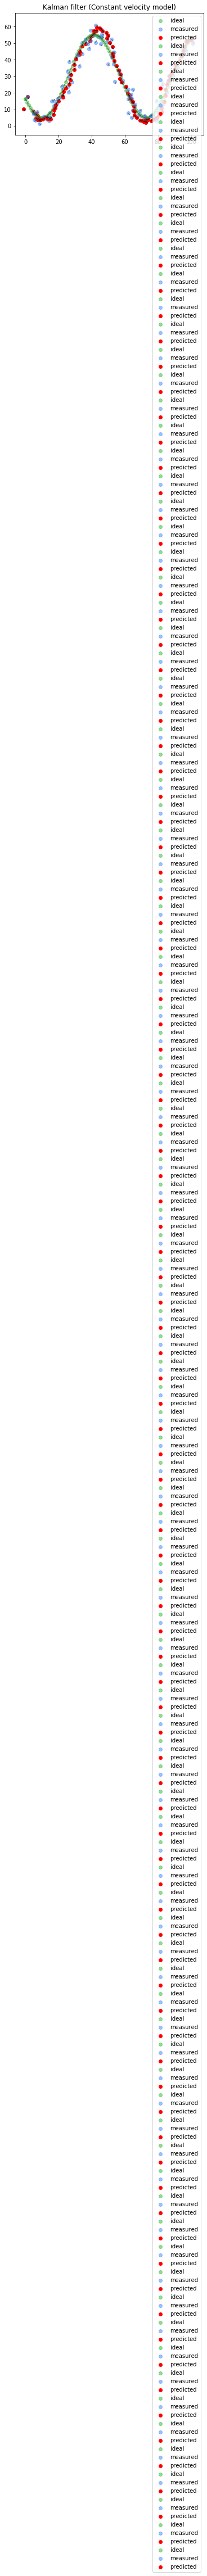

In [93]:
%matplotlib inline
# plotter initialise
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('equal')
# ax1 = plt.axes(xlim=(-5, 105), ylim=(-5, 105))

def init():
    # current state of kalman filter = m_data input
    p_dat = kf.get_state()[:3]
    # plot initial state
    vis.plot(ax1, i_dat, m_dat, p_dat)
    plt.legend()

# animate function fetches data and updates kalman filter
def animate(i):
    # get ideal and measurement data
    i_dat = next(ideal_data_f)
    m_dat = next(noisy_data_f)
    # update kalman filter
    p_dat = kf.step_update(np.matrix(m_dat[:3]))[:3]
    # plot data
    print('Processing frame: ', i)
    vis.plot(ax1, i_dat, m_dat, p_dat)

# the animator
ani = FuncAnimation(fig, animate, init_func=init,
                    interval=animation_interval_ms,
                    frames=range(0, total_iters-1), repeat=False)
plt.title('Kalman filter (Constant velocity model)')

HTML(ani.to_jshtml())

## Kalman Filter (with imu input)

### initialise path generator

In [85]:
# the path generator function
gen = dg.PathGen(coeffs=[25, 0.1, 10, 30],
                 min_t=time_lims[0], max_t=time_lims[1],
                 num=total_iters)

# gen function for ideal data
ideal_data_f = gen.ideal_data()
# gen function for noisy data
noisy_data_f = gen.noisy_data(dev=pos_dev, acc_dev=acc_dev)

# get the first frames and plot
# x, y, q, xa, ya, qa
i_dat = next(ideal_data_f)
# xn, yn, qn, xn_a, yn_a, qn_a
m_dat = next(noisy_data_f)

### initialise kalman filter

In [86]:
# initialise kalman filter (with acceleration input)
kf = KalmanFilter(np.matrix([m_dat[0], m_dat[1], m_dat[2], 0, 0, 0]),
                  np.matrix([m_dat[3:6]]),
                  p_diag, q_diag, r_diag,
                  dt=(time_lims[1] - time_lims[0]) / float(total_iters))

A: 
 [[1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
B: 
 [[0.5 0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  0.5]
 [1.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]]
U: 
 [[-0.04580488]
 [ 0.22609338]
 [ 0.00853791]]
P: 
 [[100   0   0   0   0   0]
 [  0 100   0   0   0   0]
 [  0   0 100   0   0   0]
 [  0   0   0 600   0   0]
 [  0   0   0   0 600   0]
 [  0   0   0   0   0 600]]
q_diag: 
 [[0.01 0.   0.  ]
 [0.   0.01 0.  ]
 [0.   0.   0.01]]
Q: 
 [[0.0025 0.     0.     0.005  0.     0.    ]
 [0.     0.0025 0.     0.     0.005  0.    ]
 [0.     0.     0.0025 0.     0.     0.005 ]
 [0.005  0.     0.     0.01   0.     0.    ]
 [0.     0.005  0.     0.     0.01   0.    ]
 [0.     0.     0.005  0.     0.     0.01  ]]
R: 
 [[2.2  0.   0.  ]
 [0.   2.2  0.  ]
 [0.   0.   0.05]]


### run animation with imu inputs

Processing frame:  0
Processing frame:  1
Processing frame:  2
Processing frame:  3
Processing frame:  4
Processing frame:  5
Processing frame:  6
Processing frame:  7
Processing frame:  8
Processing frame:  9
Processing frame:  10
Processing frame:  11
Processing frame:  12
Processing frame:  13
Processing frame:  14
Processing frame:  15
Processing frame:  16
Processing frame:  17
Processing frame:  18
Processing frame:  19
Processing frame:  20
Processing frame:  21
Processing frame:  22
Processing frame:  23
Processing frame:  24
Processing frame:  25
Processing frame:  26
Processing frame:  27
Processing frame:  28
Processing frame:  29
Processing frame:  30
Processing frame:  31
Processing frame:  32
Processing frame:  33
Processing frame:  34
Processing frame:  35
Processing frame:  36
Processing frame:  37
Processing frame:  38
Processing frame:  39
Processing frame:  40
Processing frame:  41
Processing frame:  42
Processing frame:  43
Processing frame:  44
Processing frame:  4

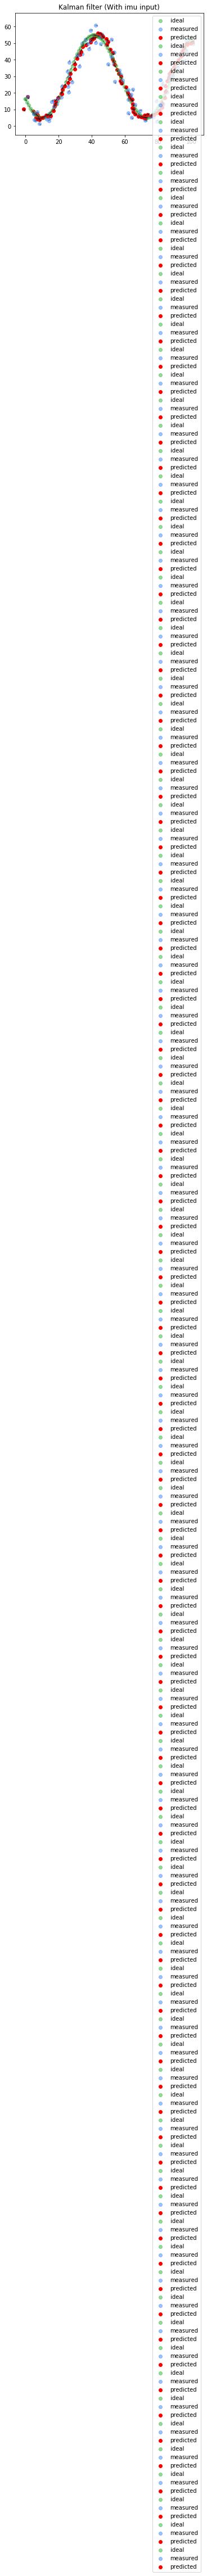

In [87]:
%matplotlib inline
# plotter initialise
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('equal')
# ax1 = plt.axes(xlim=(-5, 105), ylim=(-5, 105))

def init():
    # current state of kalman filter = m_data input
    p_dat = kf.get_state()[:3]
    # plot initial state
    vis.plot(ax1, i_dat, m_dat, p_dat)
    plt.legend()

# animate function fetches data and updates kalman filter
def animate(i):
    # get ideal and measurement data
    i_dat = next(ideal_data_f)
    m_dat = next(noisy_data_f)
    # update kalman filter
    p_dat = kf.step_update(np.matrix(m_dat[:3]), 
                            np.matrix(m_dat[3:6]))[:3]
    # plot data
    print('Processing frame: ', i)
    vis.plot(ax1, i_dat, m_dat, p_dat)

# the animator
ani = FuncAnimation(fig, animate, init_func=init,
                    interval=animation_interval_ms,
                    frames=range(0, total_iters-1), repeat=False)
plt.title('Kalman filter (with imu input)')

HTML(ani.to_jshtml())